# Mountain Car (Q-Learning)

In this section, we aim to devise a solution for the Mountain Car problem utilizing the Q-Learning technique.

In [22]:
import gym
import numpy as np
import random
import imageio 
from matplotlib import pyplot as plt

### Context

In [8]:
env = gym.make("MountainCar-v0", render_mode ="rgb_array")

In the Mountain Car problem, the state of the car is defined by two parameters: its position and velocity. 

The position of the car can range between -1.2 and 0.6. This range represents the horizontal location of the car on the track. A position of -1.2 corresponds to the far left of the track, 0.6 corresponds to the far right (the goal position), and 0 is the bottom of the valley.

The velocity of the car can range between -0.07 and 0.07. This represents the speed and direction of the car. A negative velocity means the car is moving to the left, a positive velocity means the car is moving to the right, and a velocity of 0 means the car is stationary.

The goal of the problem is to drive the car up the right-hand hill to the goal position. The car is initially stationary and not powerful enough to drive up the hill without a run-up. Therefore, the car must first drive left, away from the goal, in order to gain enough momentum to reach the goal.

In [9]:
state, info = env.reset()
state

array([-0.5833901,  0.       ], dtype=float32)

The Q-Learning algorithm is a reinforcement learning method that is typically applied to problems with a discrete state space. However, in the Mountain Car problem, the state of the car, defined by its position and velocity, is continuous because these parameters can take on any real number within a certain range.

To apply the Q-Learning algorithm to this problem, we need to convert the continuous state space into a discrete one. One approach to achieve this is by dividing the range of possible values for the position and velocity into a certain number of discrete steps.

For instance, the position of the car can range between -1.2 and 0.6. If we divide this range into steps of 0.1, we end up with 18 discrete positions that the car can be in. We can apply a similar process to the velocity of the car to discretize it.

However, the states that we get from the environment are still continuous. To map these continuous states to our discrete state space, we can round the position and velocity of the car to the nearest discrete value in our state space. This way, we can effectively apply the Q-Learning algorithm to the Mountain Car problem by treating it as a discrete state space problem.

In [10]:
low_pos, low_vel = env.observation_space.low
high_pos, high_vel = env.observation_space.high

In the context of the Mountain Car problem, we might want to increase the granularity of our state space to improve the accuracy of our model. For instance, we could choose to have 100 discrete states for both position and velocity, instead of the 18 we had previously. 

This increased granularity makes our discrete state space more closely resemble the continuous state space of the problem. Essentially, the more states we have, the more accurately we can represent the continuous range of possible positions and velocities of the car.

However, increasing the number of states comes with a trade-off. The more states we have, the longer it will take for the Q-Learning algorithm to converge to the optimal policy. This is because the algorithm needs to explore each state multiple times to accurately estimate the Q-values.

Therefore, if we decide to increase the number of states, we will also need to increase the number of maximum steps per episode and the total number of episodes (epochs). This will ensure that the algorithm has enough time to explore each state thoroughly and converge to the optimal policy.

In [11]:
POS_POINT = 100
VEL_POINT = 100

In [12]:
pos_range = np.linspace(low_pos, high_pos,POS_POINT)
vel_range = np.linspace(low_vel, high_vel,VEL_POINT)

In the Mountain Car problem, we have a continuous state space that we need to discretize in order to apply the Q-Learning algorithm. We do this by creating a range of discrete points that represent possible states for the position and velocity of the car.

Once we have this range of discrete points, we need a way to map the continuous states that we get from the environment to our discrete state space. To do this, we calculate the difference between the current state (either position or velocity) and each point in our range. The point that yields the smallest difference is the one that best represents the current state.

It's important to note that the number of discrete points (or steps) can be different for position and velocity. This is because the range of possible values for position and velocity are different, and we might want to discretize these ranges at different granularities. For instance, we might want a finer granularity for position if we believe that small changes in position have a significant impact on the outcome of the problem.

Therefore, we create two separate functions to discretize the position and velocity. These functions take as input the current state and the range of discrete points, and return the point that best represents the current state.

In [13]:
def discretize_velocity(velocity):
    # Discretize state
    index = np.argmin(np.abs(vel_range - velocity))
    return index

def discretize_position(position):
    # Discretize state
    index = np.argmin(np.abs(pos_range - position))
    return index

Now that we have determined the number of discrete steps for each state variable (position and velocity), we are in a position to create the Q-table. 

The Q-table is a key component of the Q-learning algorithm. It is a matrix where each row represents a state and each column represents an action. The value in each cell of the matrix (i.e., for each state-action pair) is the expected future reward for taking that action in that state, according to the current policy.

In the context of the Mountain Car problem, the states are defined by the position and velocity of the car, and the actions are the possible movements of the car (accelerate forward, do nothing, or accelerate backward). 

By discretizing the state space, we have effectively determined the number of rows in our Q-table. The number of columns is determined by the number of possible actions. 

With this information, we can now initialize our Q-table. At the start of the learning process, we don't have any information about the expected future rewards, so we typically initialize the Q-table with zeros. As the learning process progresses, these values will be updated based on the rewards that the agent receives for its actions.

In [14]:
qtable = np.zeros((len(pos_range), len(vel_range), env.action_space.n))
qtable.shape

(100, 100, 3)

Now is the main part!

We have all we need to make the computer learn this situation.
For a defined number of epochs, we train for the QTable. Givent the epsilon we take an action by exploring or making the best action (given by QTbale). The action give us the new state.
If the new_state position is > 0.5 or the new_state is done, the car managed to get to the top, so no need to train more, get to the next epochs.

If not, update the current state values.

In [15]:
achieve_steps = []
def QLearning(env, learning, discount, epsilon, max_steps, episodes):
    

    for i in range(episodes):
        print("Episodes n°:", i)
        state, info = env.reset()
        done = False
        decay_rate= 0.005

        state_dis = [discretize_position(state[0]), discretize_velocity(state[1])]

        for j in range(max_steps):

            if random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable[state_dis[0], state_dis[1]])

            new_state, reward, done, truncated, info = env.step(action)

            new_state_dis = [discretize_position(new_state[0]), discretize_velocity(new_state[1])]

            if done == True or new_state[0] > 0.5:
                qtable[state_dis[0], state_dis[1], action] = reward
                print("Sucessful")
                break
            
            qtable[state_dis[0], state_dis[1], action] = qtable[state_dis[0], state_dis[1], action] + learning * (reward + discount * np.max(qtable[new_state_dis[0], new_state_dis[1]])-qtable[state_dis[0], state_dis[1], action])

            state_dis = new_state_dis
        achieve_steps.append(j)

            

            
        epsilon = np.exp(-decay_rate*i)

### Let's learn!

In [16]:
QLearning(env, 0.9, 0.8, 1.0, 500, 10000)

Episodes n°: 0
Episodes n°: 1
Episodes n°: 2


c:\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episodes n°: 3
Episodes n°: 4
Episodes n°: 5
Episodes n°: 6
Episodes n°: 7
Episodes n°: 8
Episodes n°: 9
Episodes n°: 10
Episodes n°: 11
Episodes n°: 12
Episodes n°: 13
Episodes n°: 14
Episodes n°: 15
Episodes n°: 16
Episodes n°: 17
Episodes n°: 18
Episodes n°: 19
Episodes n°: 20
Episodes n°: 21
Episodes n°: 22
Episodes n°: 23
Episodes n°: 24
Episodes n°: 25
Episodes n°: 26
Episodes n°: 27
Episodes n°: 28
Episodes n°: 29
Episodes n°: 30
Episodes n°: 31
Episodes n°: 32
Episodes n°: 33
Episodes n°: 34
Episodes n°: 35
Episodes n°: 36
Episodes n°: 37
Episodes n°: 38
Episodes n°: 39
Episodes n°: 40
Episodes n°: 41
Episodes n°: 42
Episodes n°: 43
Episodes n°: 44
Episodes n°: 45
Episodes n°: 46
Episodes n°: 47
Episodes n°: 48
Episodes n°: 49
Episodes n°: 50
Episodes n°: 51
Episodes n°: 52
Episodes n°: 53
Episodes n°: 54
Episodes n°: 55
Episodes n°: 56
Episodes n°: 57
Episodes n°: 58
Episodes n°: 59
Episodes n°: 60
Episodes n°: 61
Episodes n°: 62
Episodes n°: 63
Episodes n°: 64
Episodes n°: 65

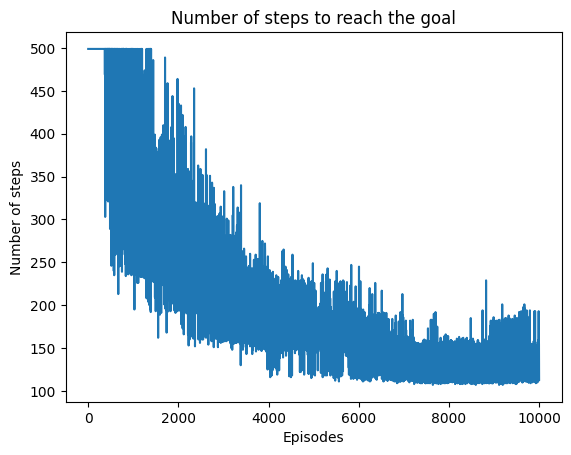

In [20]:
plt.plot(achieve_steps)
plt.title('Number of steps to reach the goal')
plt.xlabel('Episodes')
plt.ylabel('Number of steps')
plt.show()

The graph demonstrates a clear trend of convergence over time. This indicates that the Q-Learning method is indeed a viable solution for this problem. However, it's important to note that the effectiveness of this approach is contingent upon the parameters used. Specifically, it appears that a minimum of 6000 episodes is required for the Q-Learning algorithm to sufficiently learn and establish an optimal policy. 

This is because Q-Learning is an iterative process that progressively refines its understanding of the Q-values associated with each state-action pair. Each episode provides the algorithm with new experiences, from which it can learn and update the Q-values. Therefore, the more episodes the algorithm is allowed to run, the more opportunities it has to learn from new experiences and improve its policy.

However, it's also worth noting that the number of episodes required for convergence can be influenced by other factors as well, such as the learning rate and the discount factor. Adjusting these parameters could potentially reduce the number of episodes required for the Q-Learning algorithm to converge.

### Create the GIF

In [27]:
env.close()
env = gym.make("MountainCar-v0", render_mode ="rgb_array")

state,info = env.reset()

state_dis = [discretize_position(state[0]), discretize_velocity(state[1])]


images = []

while 1>0:

    action = np.argmax(qtable[state_dis[0],state_dis[1]])
    new_state, reward, done, trunc, info = env.step(action)
    frame = env.render()  # Save the frame
    images.append(frame)

    new_state_dis = [discretize_position(new_state[0]), discretize_velocity(new_state[1])]

    state_dis = new_state_dis
    if done == True:
        break

env.close()
imageio.mimsave('img/MountainCarQLearning.gif', images, fps=59)